In [42]:
from datasets import BarcelonaDataModule, BarcelonaDataset
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [96]:
data_module = BarcelonaDataModule(root="barcelona", batch_size=32, num_workers=0)

data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
val_loader = data_module.val_dataloader()

In [28]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):
       super(CNN, self).__init__()
      
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       self.fc1 = nn.Linear(129600, num_classes)

   def forward(self, x):
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(in_channels=3, num_classes=8).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=129600, out_features=8, bias=True)
)


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs=10
Loss =[]
val_acc = []
val_precision = []

for epoch in range(num_epochs):
 
    print(f"Epoch [{epoch + 1}/{num_epochs}]")


    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
    Loss.append(loss)
    
    model.eval()

    acc = MulticlassAccuracy(num_classes=8).to(device)
    precision = MulticlassPrecision(num_classes=8).to(device)

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="validation Batches"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            acc.update(preds, labels)
            precision.update(preds, labels)

    test_acc = acc.compute()
    test_precision = precision.compute()
    val_acc.append(test_acc)
    val_precision.append(test_precision)


Epoch [1/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.84it/s]


Epoch [2/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.64it/s]


Epoch [3/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.68it/s]


Epoch [4/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.74it/s]


Epoch [5/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.74it/s]


Epoch [6/10]


validation Batches: 100%|██████████| 51/51 [00:11<00:00,  4.25it/s]


Epoch [7/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.69it/s]


Epoch [8/10]


validation Batches: 100%|██████████| 51/51 [01:31<00:00,  1.80s/it]


Epoch [9/10]


validation Batches: 100%|██████████| 51/51 [01:30<00:00,  1.77s/it]


Epoch [10/10]


validation Batches: 100%|██████████| 51/51 [01:33<00:00,  1.83s/it]


In [97]:
torch.save(model.state_dict(), "mon_model_trained.pth")
print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


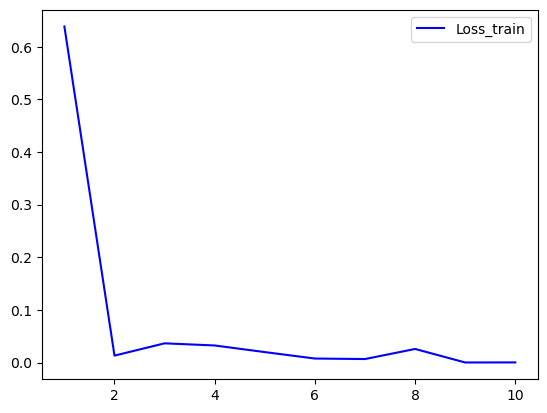

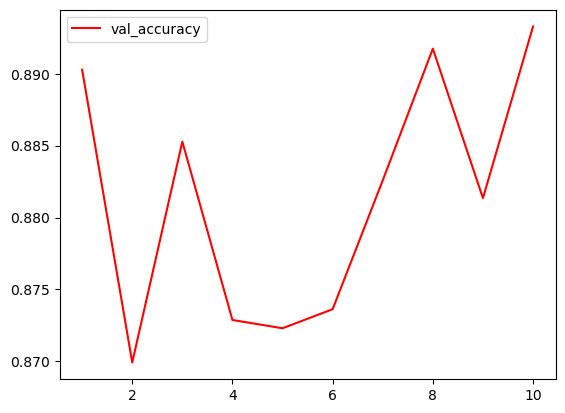

In [32]:
plt.figure()
X=[i for i in range(1,11)]
nLoss= [Loss[i].item() for i in range(len(Loss))]

plt.plot(X,nLoss, label= "Loss_train", color="blue")

plt.legend()
plt.show()


plt.figure()
nval_acc= [val_acc[i].item() for i in range(len(val_acc))]
plt.plot(X,nval_acc, label= "val_accuracy", color = "red")
plt.legend()
plt.show()


In [33]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
from tqdm import tqdm  

model.eval()

acc = MulticlassAccuracy(num_classes=8).to(device)
precision = MulticlassPrecision(num_classes=8).to(device)


with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Batches"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc.update(preds, labels)
        precision.update(preds, labels)

test_acc = acc.compute()
test_precision = precision.compute()

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")


Test Batches: 100%|██████████| 27/27 [00:49<00:00,  1.83s/it]

Test accuracy: 0.9205
Test precision: 0.9235


Test Batches: 100%|██████████| 27/27 [00:51<00:00,  1.90s/it]


IndexError: index 63 is out of bounds for dimension 0 with size 63

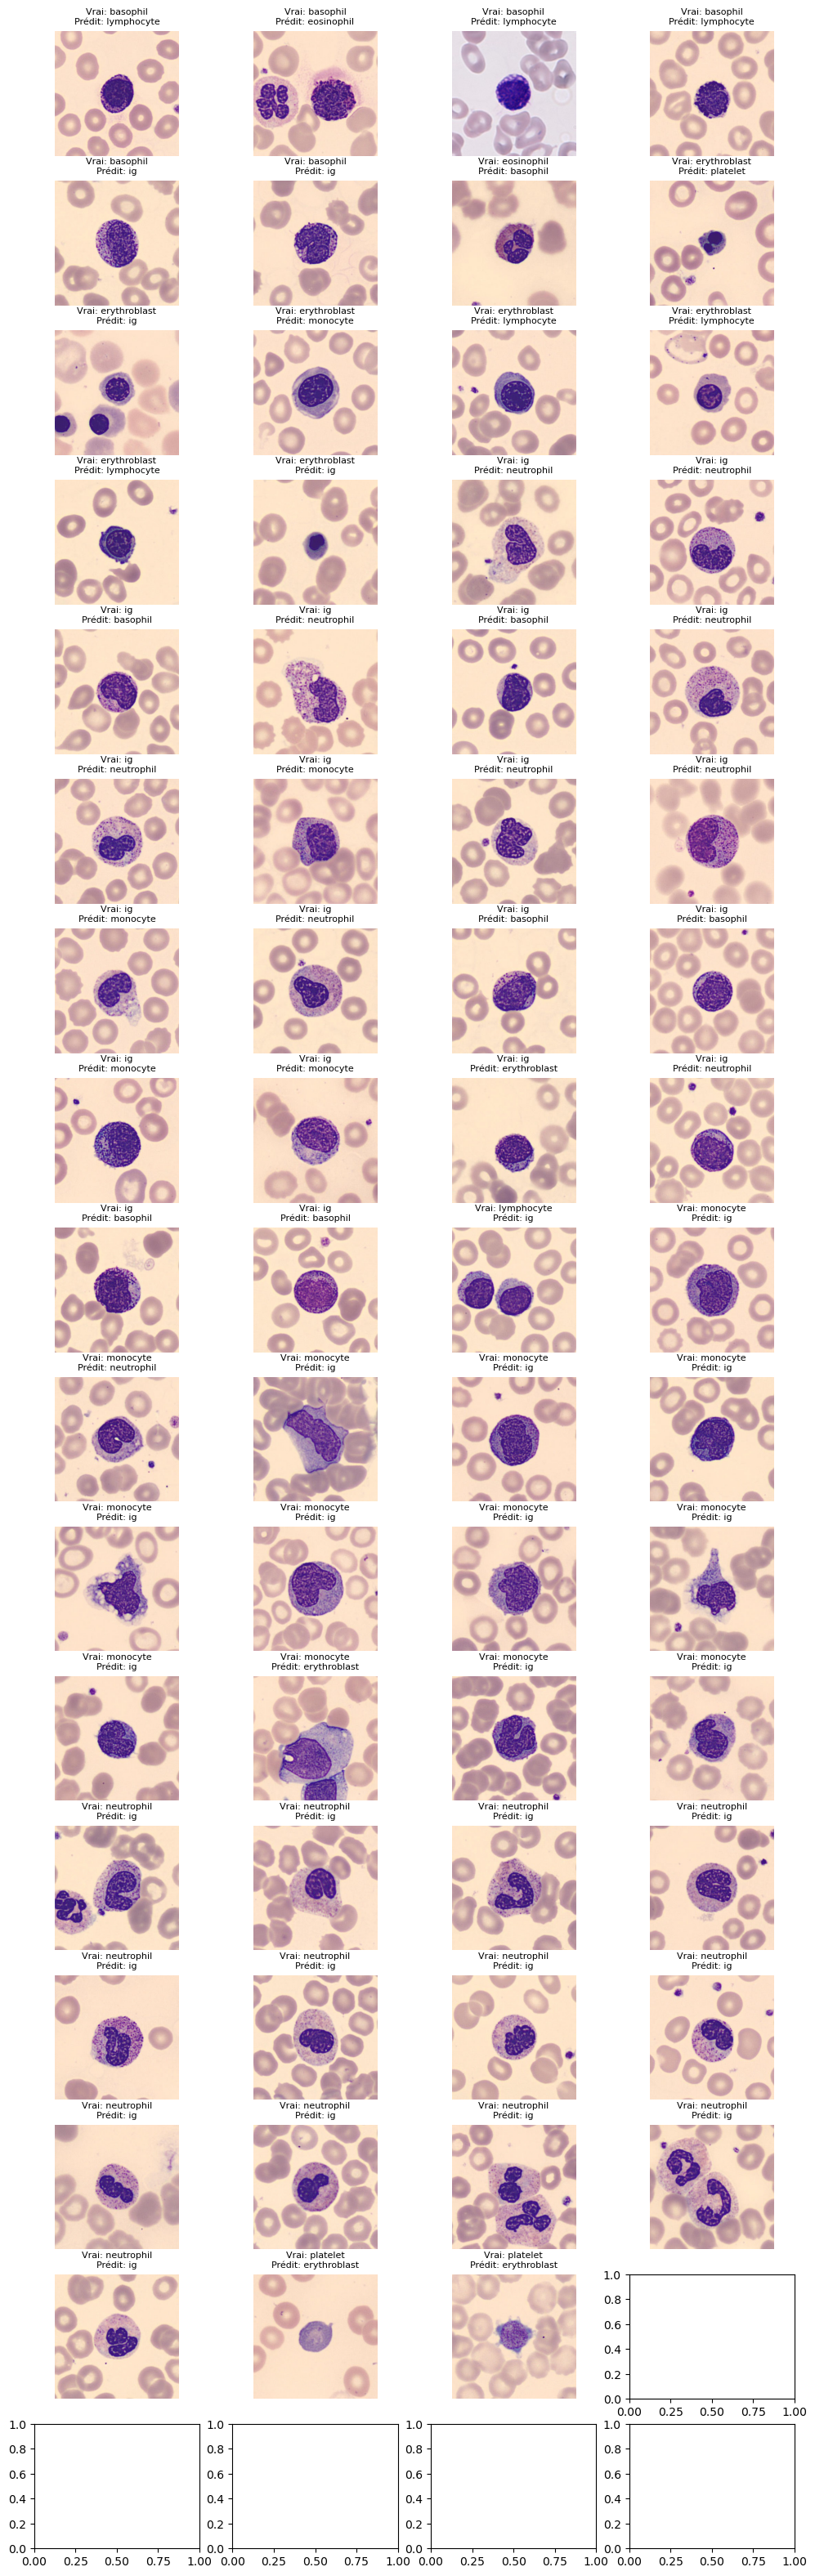

In [34]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)

    error_images = []
    error_labels = []
    error_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Test Batches"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            incorrect = preds != labels
            if incorrect.any():
                error_images.append(images[incorrect])
                error_labels.append(labels[incorrect])
                error_preds.append(preds[incorrect])

    images = torch.cat(error_images)
    labels = torch.cat(error_labels)
    preds = torch.cat(error_preds)


    fig, axes = plt.subplots(17, 4, figsize=(12, 40))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        
        img = images[i].cpu().permute(1, 2, 0) * torch.tensor(data_module.std) + torch.tensor(data_module.mean)
        img = img.clamp(0, 1)  # Corrige les couleurs après normalisation
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation :
show_predictions(model, data_module.test_dataloader(), data_module.train_ds.classes)





100%|██████████| 27/27 [01:10<00:00,  2.60s/it]


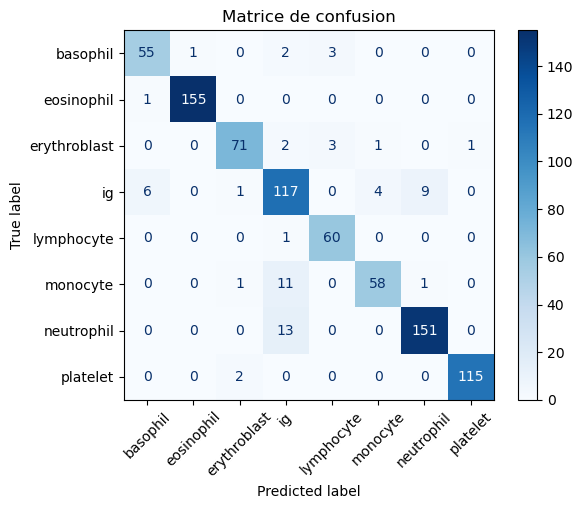

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, class_names, device="cuda"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()


# utiliser tensorboard
# Exemple d’appel
compute_confusion_matrix(model, data_module.test_dataloader(), data_module.train_ds.classes)


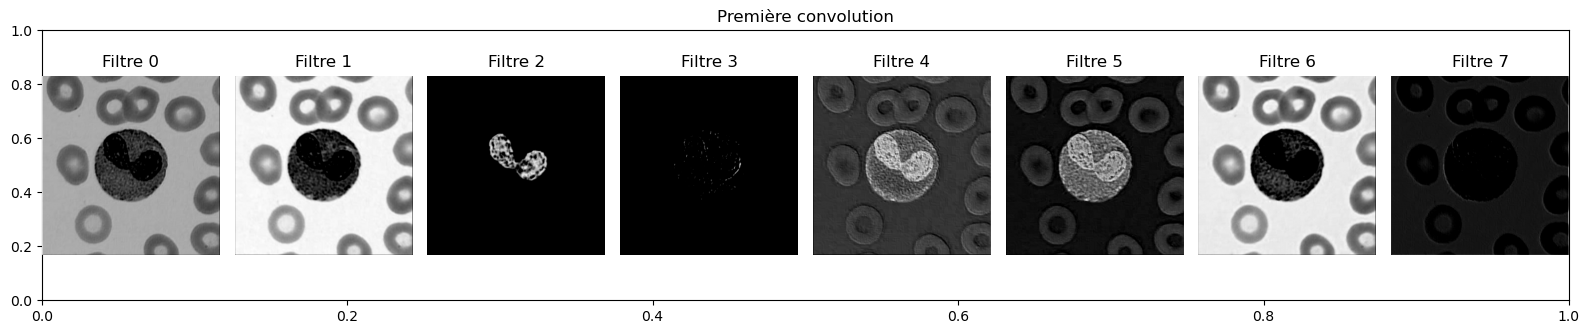

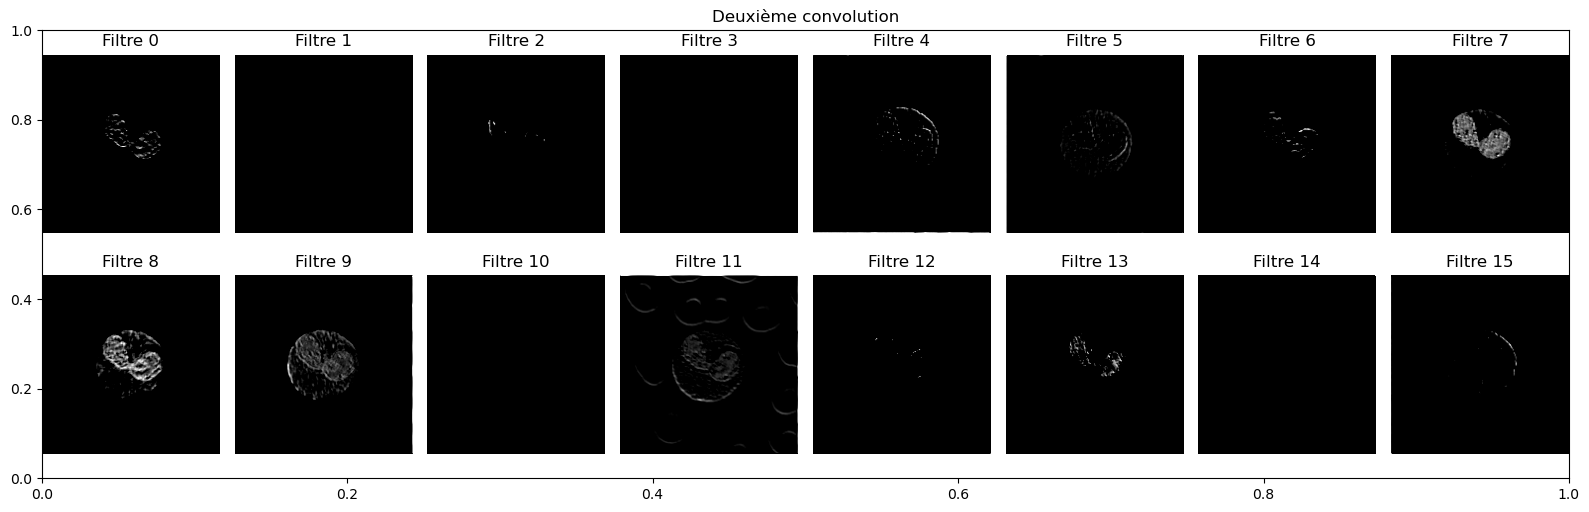

[-32.117847   -4.7924967  -9.912429   -1.9483515 -40.27903   -18.904152
   7.518343   10.22259  ]


In [95]:
import math
import matplotlib.pyplot as plt

img_path = './barcelona/barcelona/test/eosinophil/eo_33913.jpg'
img = Image.open(img_path).convert('RGB')  


transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0)  

with torch.no_grad():
    model.eval()
    img_tensor = img_tensor.to(next(model.parameters()).device)  
    features1 = F.relu(model.conv1(img_tensor) )
    features2 = model.pool(features1)
    features3 = F.relu(model.conv2(features2) )
    features4 = model.pool(features3)
    features5 = features4.reshape(features4.shape[0], -1)
    features6 = model.fc1(features5)

import math
import matplotlib.pyplot as plt

n_maps1 = features1.shape[1]
cols = 8
rows = math.ceil(n_maps1 / cols)

plt.figure(figsize=(cols * 2, rows * 2+1))
plt.title('Première convolution')
for i in range(n_maps1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(features1[0, i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filtre {i}')
plt.tight_layout()
plt.show()



n_maps3 = features3.shape[1]
cols = 8
rows3 = math.ceil(n_maps3 / cols)

plt.figure(figsize=(cols * 2, rows3 * 2+1))
plt.title('Deuxième convolution')
for i in range(n_maps3):
    plt.subplot(rows3, cols, i + 1)
    plt.imshow(features3[0, i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filtre {i}')
plt.tight_layout()
plt.show()

n_maps4 = features6.shape[1]
cols = 8
rows4 = math.ceil(n_maps4 / cols)

print(features6[0].cpu().numpy())
